<a href="https://colab.research.google.com/github/RuoxueWang-lab/Linear-regression-ML-/blob/main/Linear_Regression_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from scipy import stats

sns.set()

In [3]:
df = pd.read_csv("/housing.csv")
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


##Check whether we have missing values

In [4]:
df.isna().sum()

,0
longitude,0
latitude,0
housing_median_age,0
total_rooms,0
total_bedrooms,207
population,0
households,0
median_income,0
median_house_value,0
ocean_proximity,0


In [5]:
df[df['total_bedrooms'].isna()].head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
290,-122.16,37.77,47.0,1256.0,NaN,570.0,218.0,4.3750,161900.0,NEAR BAY
341,-122.17,37.75,38.0,992.0,NaN,732.0,259.0,1.6196,85100.0,NEAR BAY
538,-122.28,37.78,29.0,5154.0,NaN,3741.0,1273.0,2.5762,173400.0,NEAR BAY
563,-122.24,37.75,45.0,891.0,NaN,384.0,146.0,4.9489,247100.0,NEAR BAY
696,-122.10,37.69,41.0,746.0,NaN,387.0,161.0,3.9063,178400.0,NEAR BAY


Since the total_bedrooms column represents the total number of bedrooms within a block, so it's fine that we replace those null values by 0.

In [6]:
df.fillna(0, inplace=True)

##Check whether we have duplicated values

In [7]:
df.duplicated().sum()

0

##Determine the type of each value

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20640 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [9]:
df.nunique()

,0
longitude,844
latitude,862
housing_median_age,52
total_rooms,5926
total_bedrooms,1924
population,3888
households,1815
median_income,12928
median_house_value,3842
ocean_proximity,5


Hence ocean_proximity should be categorial.

##One-hot Encoding

In [10]:
df["ocean_proximity"] = df["ocean_proximity"].astype("category")

In [11]:
df = pd.get_dummies(df, columns=["ocean_proximity"], drop_first=True)
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,False,False,True,False
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,False,False,True,False
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,False,False,True,False
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,False,False,True,False
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,False,False,True,False


##Remove outliers

Visualise outliers first

['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value']


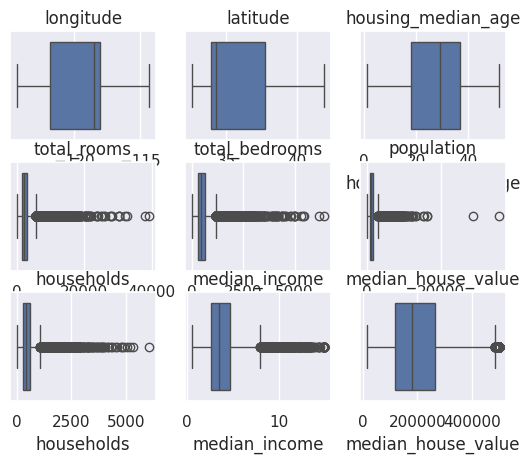

In [12]:
#Get a list of numerical features
columns_list = list(df.columns)
non_numerical_features = columns_list[-1: -5:-1]
for feature in non_numerical_features:
    columns_list.remove(feature)
numerical_features = columns_list
print(numerical_features)

#Box plot
for i, feature in enumerate(numerical_features):
    plt.subplot(3,3,i+1)
    sns.boxplot(x=df[feature])
    plt.title(f'{feature}')
plt.show()

Remove outliers that lies outside of 1.5 * IQR

In [13]:
def remove_outliers(df, feature):
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - IQR*1.5
    upper_bound = Q3 + IQR*1.5
    return df[df[feature] < upper_bound][df[feature]>lower_bound]

for feature in numerical_features:
  df = remove_outliers(df, feature)

df.shape


<ipython-input-13-f00cae0396f0>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return df[df[feature] < upper_bound][df[feature]>lower_bound]
<ipython-input-13-f00cae0396f0>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return df[df[feature] < upper_bound][df[feature]>lower_bound]
<ipython-input-13-f00cae0396f0>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return df[df[feature] < upper_bound][df[feature]>lower_bound]
<ipython-input-13-f00cae0396f0>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return df[df[feature] < upper_bound][df[feature]>lower_bound]
<ipython-input-13-f00cae0396f0>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return df[df[feature] < upper_bound][df[feature]>lower_bound]
<ipython-input-13-f00cae0396f0>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return df[df

(16897, 13)

In [14]:
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,False,False,True,False
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,False,False,True,False
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,False,False,True,False
5,-122.25,37.85,52.0,919.0,213.0,413.0,193.0,4.0368,269700.0,False,False,True,False
6,-122.25,37.84,52.0,2535.0,489.0,1094.0,514.0,3.6591,299200.0,False,False,True,False


##Data Visualisation

In [15]:
df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,16897.000000,16897.000000,16897.000000,16897.000000,16897.000000,16897.000000,16897.000000,16897.000000,16897.000000
mean,-119.613540,35.714259,29.665444,2072.326153,422.704622,1149.721903,399.450317,3.576326,185301.195242
std,2.005822,2.173686,12.210249,1025.934907,203.993527,549.913994,186.210708,1.446046,92005.431798
min,-124.350000,32.540000,1.000000,2.000000,0.000000,3.000000,2.000000,0.499900,14999.000000
25%,-121.780000,33.940000,19.000000,1346.000000,278.000000,753.000000,267.000000,2.482100,112500.000000
50%,-118.700000,34.400000,30.000000,1931.000000,399.000000,1086.000000,379.000000,3.395000,169000.000000
75%,-118.030000,37.750000,38.000000,2686.000000,554.000000,1505.000000,520.000000,4.500000,240400.000000
max,-114.490000,41.950000,52.000000,5688.000000,1053.000000,2722.000000,908.000000,8.015800,457800.000000


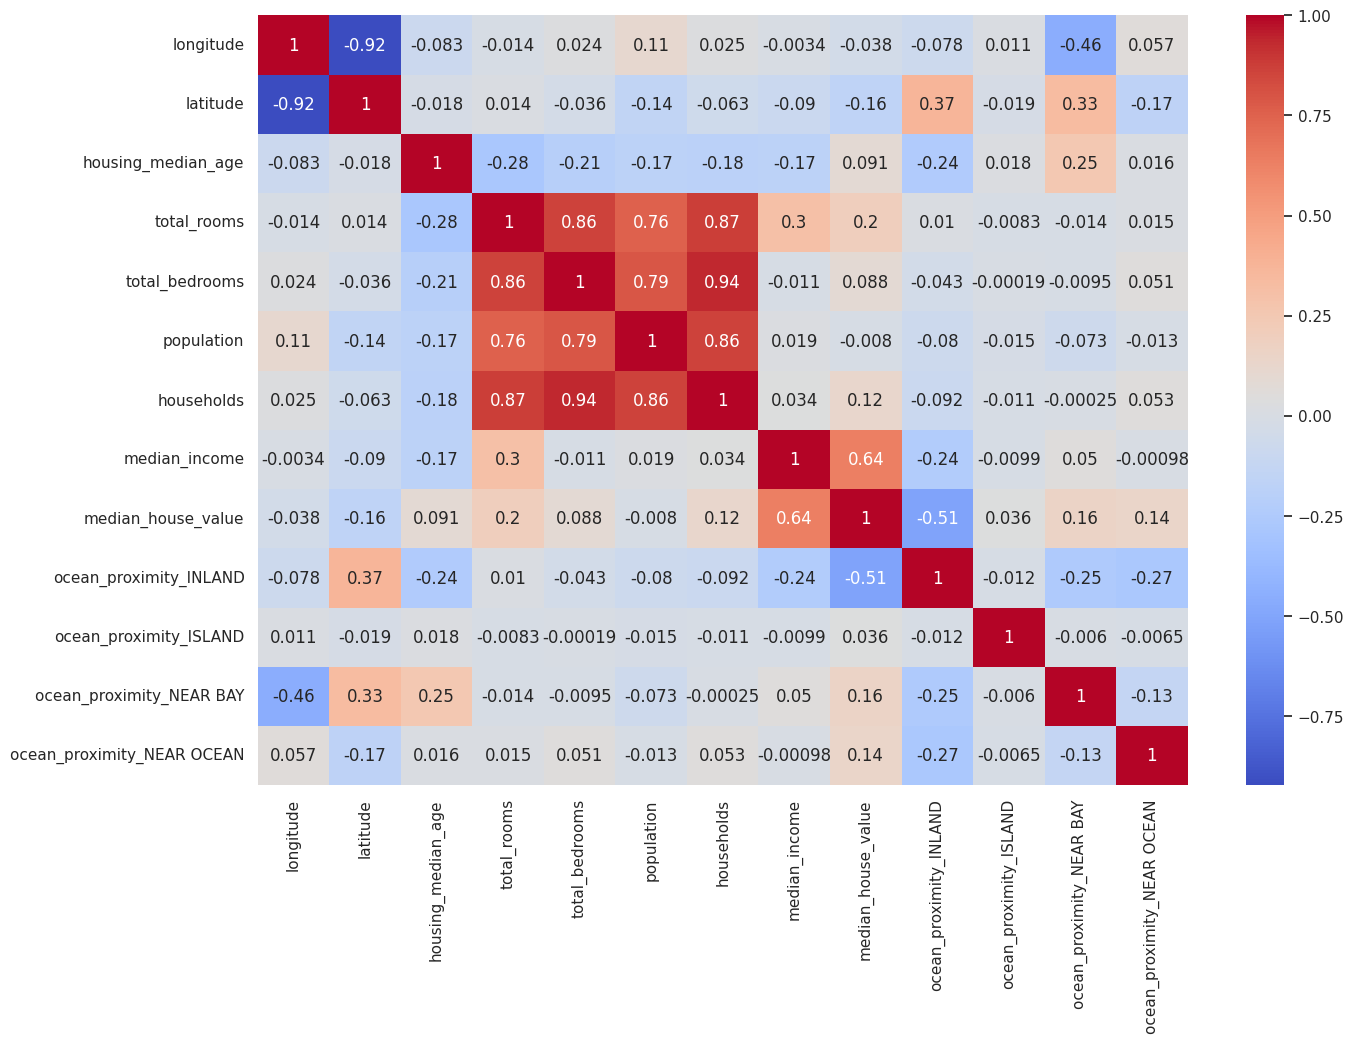

In [16]:
plt.figure(figsize=(15,10))
sns.heatmap(df.corr(), cmap='coolwarm',annot=True)
plt.show()

##Normalisation

In [17]:
scaler = MinMaxScaler()
df_normalized = df.copy()
df_normalized[numerical_features] = scaler.fit_transform(df[numerical_features])

##Split dataset into Test and Train sets

In [18]:
X = df_normalized.drop("median_house_value", axis=1, inplace=False)
y = df_normalized["median_house_value"]

from sklearn.model_selection import train_test_split

X_test, X_train, y_test, y_train = train_test_split(X, y, test_size=0.2, random_state=42)

##Apply Linear Regression Model

In [19]:
reg_model = LinearRegression()
reg_model.fit(X_train, y_train)

LinearRegression()

Predictions

In [20]:
y_hat = reg_model.predict(X_test)
#Convert our results into a dataframe
test_predictions = pd.DataFrame({'actuals':y_test, 'predictions':y_hat, 'resid': y_test-y_hat })
test_predictions

,actuals,predictions,resid
2232,0.145666,0.206237,-0.060571
17757,0.401537,0.512363,-0.110826
8140,0.467255,0.491909,-0.024654
10611,0.566622,0.547482,0.019140
18845,0.149279,0.129875,0.019405
...,...,...,...
13800,0.172314,0.182964,-0.010649
14615,0.389568,0.290113,0.099455
6423,0.368339,0.136401,0.231939
975,0.493000,0.510780,-0.017780


Parameters

In [23]:
coefficients = reg_model.coef_
intercept = reg_model.intercept_
print(coefficients)
print(intercept)

[-0.51036282 -0.46074727  0.09537226 -0.02273509  0.128162   -0.40004697
  0.31960683  0.61372326 -0.08743037  0.31971395 -0.03233258 -0.00465485]
0.49890890324340226


##Evaluation metrics

R-squared

In [24]:
reg_model.score(X_train, y_train)

0.6110811310816608

MSE and RMSE


In [26]:
MSE_test = np.mean(np.square(test_predictions["resid"]))
RMSE_test = np.sqrt(MSE_test)

print(MSE_test)
print(RMSE_test)

0.01610254074500706
0.1268957869474281


##Cross Validation

Here, we don't have any hyper parameters in the model, so we will use cross validation to estimate the test set evaluation metrics!

In [27]:
from sklearn.model_selection import cross_val_score

In [30]:
R2 = cross_val_score(estimator=LinearRegression(), X=X_train, y=y_train, cv=5, scoring="r2")
R2

array([0.57214803, 0.59443903, 0.62549735, 0.62180605, 0.61709561])

In [32]:
R2_CV = np.mean(R2)
R2_CV

0.6061972129012565

This is the estimated R squared test value.

In [35]:
MSE = -cross_val_score(estimator=LinearRegression(), X=X_train, y=y_train, cv=5, scoring="neg_mean_squared_error") #Don't forget to add the negaitive sign
MSE_CV = np.mean(MSE)
MSE_CV

0.01696345144493507

In [36]:
RMSE_CV = np.sqrt(MSE_CV)
RMSE_CV

0.1302438153807507

These are the estimated MSE_test and RMSE_test.